In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

## Prepare Data 


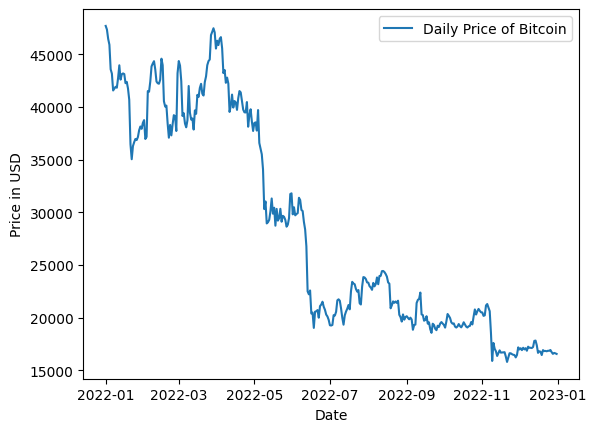

In [2]:
#Load in data
df = pd.read_csv(r"C:\Users\Owner\Documents\Predicting Crypto Prices via Senitment Analysis\BTC-USD.csv")

prices = df["Close"].values

dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
ts = pd.Series(prices, index=dates)

plt.plot(ts)
plt.legend(['Daily Price of Bitcoin'])
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.show()

### Plot ACF 

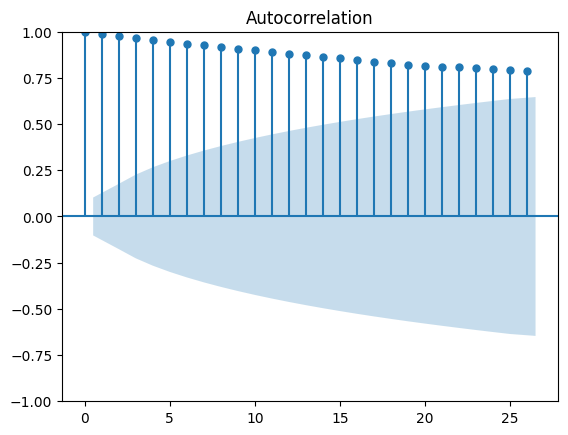

In [3]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(prices)
plt.show()

### Create log returns of bitcoin price

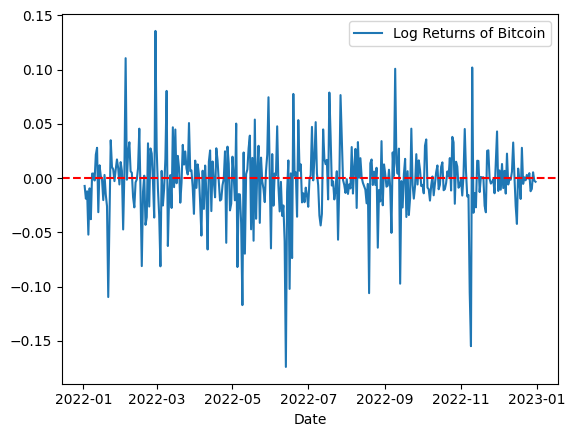

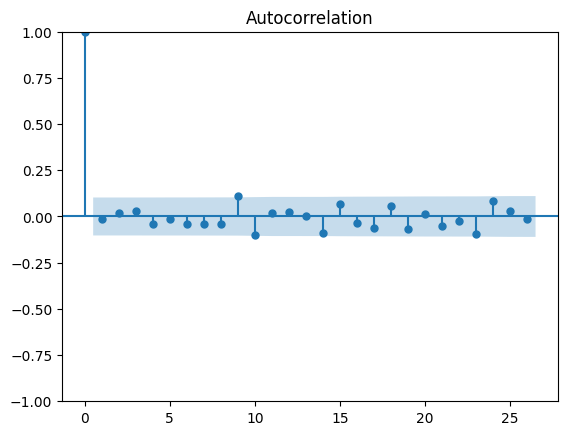

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


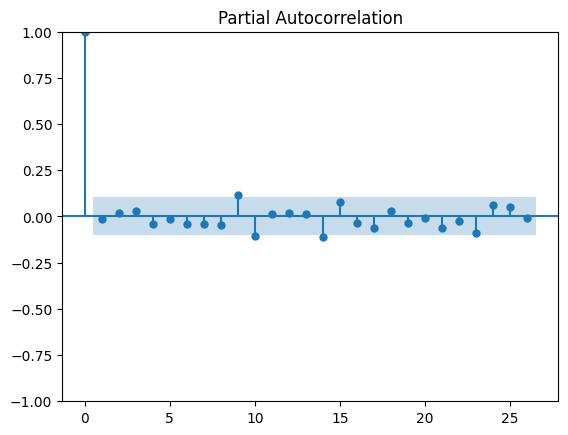

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf

log_P = np.log(prices)

#1st difference of ts to remove trend and seasonality
diff = []
for i in range(1, len(log_P)):
 value = log_P[i] - log_P[i - 1]
 diff.append(value)

diff = np.array(diff)
diff = diff.astype('float32')

dates_4_diff = pd.date_range(start='2022-01-02', end='2022-12-31', freq='D')
timeseries_indexed = pd.Series(diff, index=dates_4_diff)

plt.plot(timeseries_indexed)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(["Log Returns of Bitcoin"])
plt.xlabel("Date")
plt.show()

plot_acf(diff)
plt.show()

plot_pacf(diff)
plt.show()

diff.resize((364,1)) #necessary to make sure the code works


### Use ADF Test to check for stationarity


In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -19.230854
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


### Train-Test Split

In [6]:
# train-test split for time series
train_size = int(len(diff) * 0.67)
test_size = len(diff) - train_size
train, test = diff[:train_size], diff[train_size:]

print(len(train))
print(len(test))

243
121


In [7]:
# train-test split for time series
train_size = int(len(log_P) * 0.67)
test_size = len(log_P) - train_size
train_p, test_p = log_P[:train_size], log_P[train_size:]

print(len(train))
print(len(test))

243
121


### Create tensor dataset

In [8]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    return torch.tensor(X), torch.tensor(y)

lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\Owner\AppData\Local\Temp\ipykernel_27220\3695930555.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


## LSTM Class


In [9]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=60, num_layers=1, batch_first=True)
        self.linear = nn.Linear(60, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

## Training


In [10]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=1)

n_epochs = 1400
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        y_pred = y_pred.unsqueeze(2)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred = y_pred.unsqueeze(2)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        
        y_pred = model(X_test)
        y_pred = y_pred.unsqueeze(2)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 

Epoch 0: train RMSE 0.0374, test RMSE 0.0301
Epoch 100: train RMSE 0.0357, test RMSE 0.0288
Epoch 200: train RMSE 0.0339, test RMSE 0.0296
Epoch 300: train RMSE 0.0311, test RMSE 0.0332
Epoch 400: train RMSE 0.0238, test RMSE 0.0349
Epoch 500: train RMSE 0.0190, test RMSE 0.0363
Epoch 600: train RMSE 0.0121, test RMSE 0.0353
Epoch 700: train RMSE 0.0095, test RMSE 0.0368
Epoch 800: train RMSE 0.0079, test RMSE 0.0366
Epoch 900: train RMSE 0.0060, test RMSE 0.0362
Epoch 1000: train RMSE 0.0054, test RMSE 0.0365
Epoch 1100: train RMSE 0.0053, test RMSE 0.0360
Epoch 1200: train RMSE 0.0040, test RMSE 0.0352
Epoch 1300: train RMSE 0.0056, test RMSE 0.0363


## Plotting Results of LSTM



In [13]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(diff) * np.nan
    y_hat_train = model(X_train)
    
    rmse_train = np.sqrt(loss_fn(y_hat_train.unsqueeze(2), y_train))
    
    train_plot[lookback:train_size] = y_hat_train
    # shift test predictions for plotting
    test_plot = np.ones_like(diff) * np.nan
    y_hat_test = model(X_test)

    rmse_test = np.sqrt(loss_fn(y_hat_test.unsqueeze(2), y_test))

    test_plot[train_size+lookback:len(diff)] = y_hat_test

print(rmse_train)
print(rmse_test)


# plot
plt.plot(diff)
plt.plot(train_plot, c='r', label="Training Y-Hats")
plt.plot(test_plot, c='g', label='Testing Y-Hats')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
#plt.savefig("365 forecast")

ValueError: could not broadcast input array from shape (233,1) into shape (234,1)

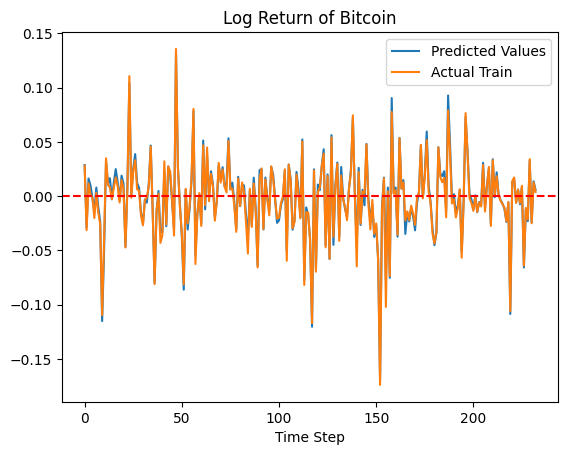

NameError: name 'y_hat_test' is not defined

In [12]:
plt.plot(y_hat_train, label="Predicted Values")
plt.plot(y_train.squeeze(), label="Actual Train")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.show()
# plt.savefig("Trained.png")

plt.plot(y_hat_test, label="Predicted Values")
plt.plot(y_test.squeeze(), label="Actual Test")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.savefig("Test.png")
plt.show()